In [1]:
import os
import pickle
import PIL.Image
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from helpers.custom_classifier import CustomClassifier
from helpers.early_stopping import EarlyStopping

In [2]:
num_epochs = 25

In [3]:
class CrackDataset(Dataset):
    def __init__(self, images_dir, transform: transforms.Compose):
        self.images_dir = images_dir
        self.image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = PIL.Image.open(img_path).convert("RGB")
        label = 0 if "noncrack" in img_name else 1
        image = self.transform(image)

        return image, label

In [4]:
def get_loaders() -> tuple[DataLoader, DataLoader]:
    batch_size = 32
    train_images_dir = os.path.join("data", "train", "images")
    valid_images_dir = os.path.join("data", "valid", "images")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    train_dataset = CrackDataset(train_images_dir, transform=transform)
    valid_dataset = CrackDataset(valid_images_dir, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, valid_loader

In [5]:
def get_loop_objects(
        conv_out_shapes: tuple[int, int],
        linear_layers_features: int
) -> tuple[CustomClassifier, EarlyStopping, torch.nn.BCEWithLogitsLoss, optim.Adam, torch.device]:
    model = CustomClassifier(conv_out_shapes=conv_out_shapes, linear_layers_features=linear_layers_features)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    early_stopping = EarlyStopping(patience=7, verbose=True, delta=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    
    return model, early_stopping, criterion, optimizer, device

In [6]:
def validate(
        model: CustomClassifier, 
        valid_loader: DataLoader, 
        criterion: torch.nn.BCEWithLogitsLoss, 
        history: dict[str, list[float]]
) -> tuple[float, float]:
    model.eval()

    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct_valid += predicted.eq(labels).sum().item()
            total_valid += labels.size(0)
    
    valid_loss /= len(valid_loader.dataset)
    history["valid_loss"].append(valid_loss)
    
    return 100. * correct_valid / total_valid, valid_loss
    

def run_training_loop(
        conv_out_shapes: tuple[int, int], 
        linear_layers_features: int,
        checkpoint_path: str,
        history_path: str
) -> tuple[dict, float]:
    train_loader, valid_loader = get_loaders()
    model, early_stopping, criterion, optimizer, device = get_loop_objects(conv_out_shapes, linear_layers_features)
    history = {
        "train_loss": [],
        "valid_loss": []
    }
    valid_accuracy = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
    
        with tqdm(train_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
    
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device).float()
    
                optimizer.zero_grad()
    
                # squeeze because the outputs are (BATCH_SIZE, 1) shape, and should be of (BATCH_SIZE,) shape
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
    
                loss.backward()
                optimizer.step()
    
                train_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct_train += predicted.eq(labels).sum().item()
                total_train += labels.size(0)
    
                tepoch.set_postfix(loss=train_loss/total_train, accuracy=100.*correct_train/total_train)

        valid_accuracy, valid_loss = validate(model, valid_loader, criterion, history)
        train_loss /= len(train_loader.dataset)
        history["train_loss"].append(train_loss)
    
        print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")
        early_stopping(valid_loss, model, path=checkpoint_path)
    
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    with open(history_path, "wb") as history_file:
        pickle.dump(history, history_file)
            
    return history, valid_accuracy

In [7]:
model_results = []
param_combinations = [
    {
        "conv_out_shapes": (64, 128),
        "linear_layers_features": 256,
    },
    {
        "conv_out_shapes": (128, 256),
        "linear_layers_features": 512,
    },
    {
        "conv_out_shapes": (64, 128),
        "linear_layers_features": 512,
    },
    {
        "conv_out_shapes": (64, 128),
        "linear_layers_features": 1024,
    },
]

for param_combination in param_combinations:
    model_custom_path = "_".join(map(str, param_combination["conv_out_shapes"]))
    model_custom_path = f"{param_combination['linear_layers_features']}_{model_custom_path}"
    checkpoint_path = os.path.join("checkpoints", f"custom_classifier_{model_custom_path}.pt")
    history_path = os.path.join("checkpoints", f"history_{model_custom_path}.pkl")

    if os.path.exists(checkpoint_path):
        with open(history_path, "rb") as history_file:
            history = pickle.load(history_file)

        model, _, criterion, _, device = get_loop_objects(
            param_combination["conv_out_shapes"], 
            param_combination["linear_layers_features"]
        )
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        model.load_state_dict(checkpoint)

        _, valid_loader = get_loaders()
        valid_accuracy, valid_loss = validate(model, valid_loader, criterion, {"valid_loss": []})
        
        model_results.append((checkpoint_path, history, valid_accuracy))
        print(f"Checkpoint already exists for {checkpoint_path}. Skipping...")
    else:
        history, validation_acc = run_training_loop(
            param_combination["conv_out_shapes"], 
            param_combination["linear_layers_features"], 
            checkpoint_path,
            history_path
        )
    
        model_results.append((checkpoint_path, history, validation_acc))
        torch.cuda.empty_cache()

C:\Users\mmale\AppData\Local\Temp\ipykernel_1460\436270072.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

Checkpoint already exists for checkpoints\custom_classifier_256_64_128.pt. Skipping...
Checkpoint already exists for checkpoints\custom_classifier_512_128_256.pt. Skipping...
Checkpoint already exists for checkpoints\custom_classifier_512_64_128.pt. Skipping...
Checkpoint already exists for checkpoints\custom_classifier_1024_64_128.pt. Skipping...


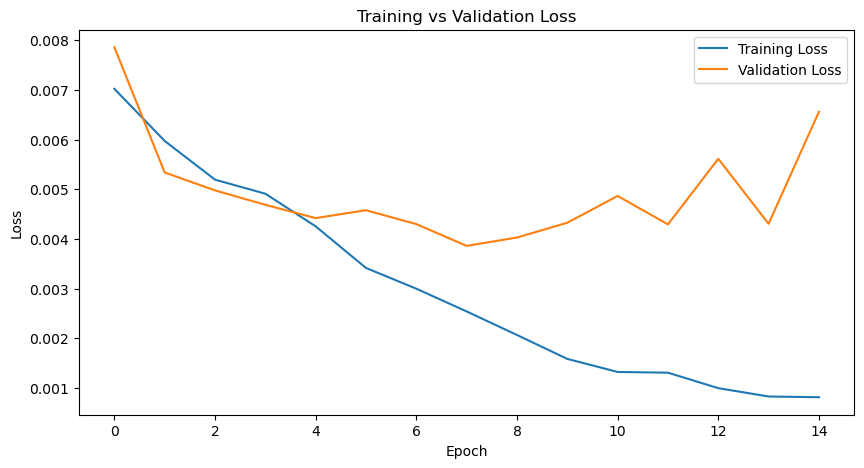

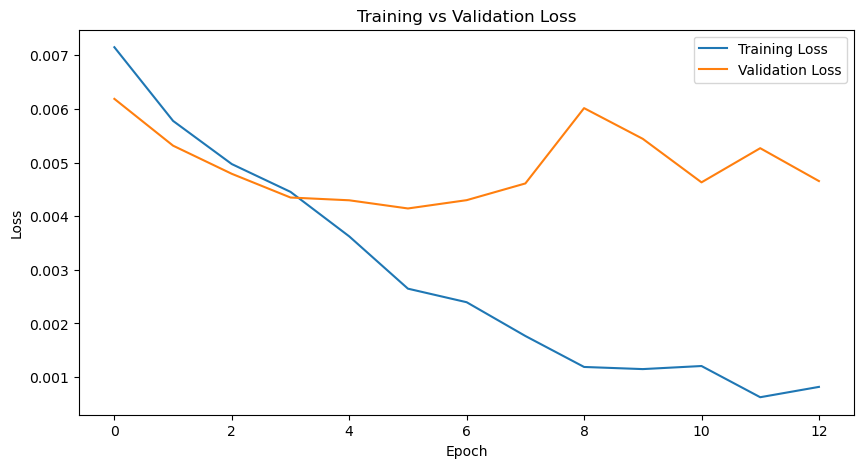

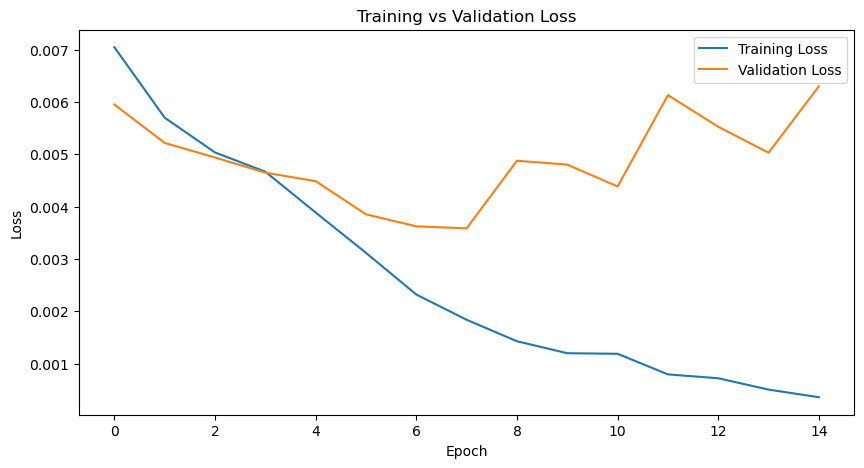

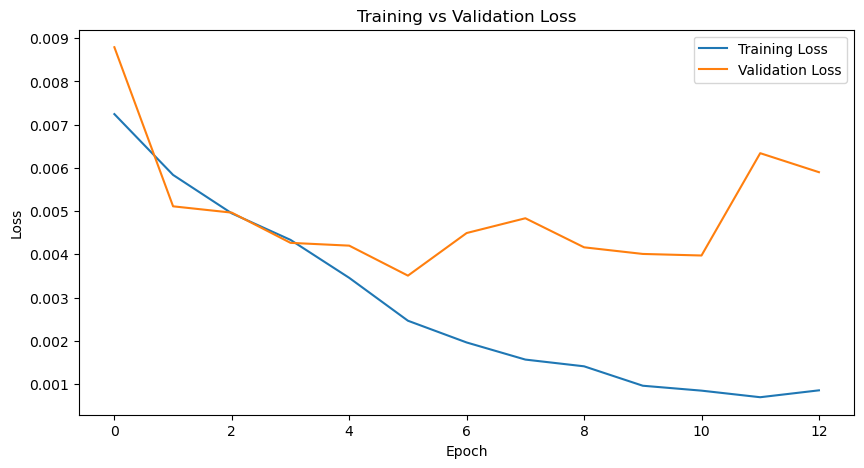

In [8]:
for row in model_results:
    history = row[1]
    
    plt.figure(figsize=(10, 5))
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["valid_loss"], label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [9]:
max_tuple = max(model_results, key=lambda x: x[2])

print(f"Max model accuracy is: {max_tuple[2]}, checkpoint path: {max_tuple[0]}")

Max model accuracy is: 96.40117994100295, checkpoint path: checkpoints\custom_classifier_1024_64_128.pt
